# **뉴런 커버리지 테스트**

## **1. Tensorflow 기반**

### **1.1 기본 설정**

In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
# 한글폰트 설치하기 위해 필요한 모듈
import matplotlib.font_manager as fm

In [22]:
# 나눔바른고딕 폰트 설치 - 런타임 연결이 다시 될 때마다 다시 폰트를 설치해야 한글이 보인다.
!apt install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,899 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [23]:
# 폰트 적용
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
plt.rcParams['font.family'] = "NanumBarunGothic"

In [24]:
# 마이너스(음수)부호 설정
plt.rc("axes", unicode_minus = False)

In [12]:
# 시드 설정
tf.random.set_seed(6)
np.random.seed(6)

### **1.2 뉴런 커버리지 측정 클래스**

In [18]:
# 뉴런 커버리지 측정을 위한 클래스
class NeuronCoverage:
    def __init__(self, model, threshold=0.5):
        """
        뉴런 커버리지를 측정하는 클래스

        Args:
            model: 테스트할 모델
            threshold: 뉴런 활성화 임계값 (기본값: 0.5)
        """
        self.model = model
        self.threshold = threshold
        self.layer_names = []
        self.covered_neurons = {}
        self.total_neurons = {}

        # Dense 또는 Conv2D 레이어만 추적
        for i, layer in enumerate(model.layers):
            if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
                layer_name = f"{i}_{layer.name}"
                self.layer_names.append(layer_name)

                # 출력 형태 확인
                if isinstance(layer, tf.keras.layers.Dense):
                    num_neurons = layer.units
                else:  # Conv2D
                    num_neurons = layer.filters

                self.covered_neurons[layer_name] = np.zeros(num_neurons, dtype=bool)
                self.total_neurons[layer_name] = num_neurons

        # 레이어 출력을 추적하기 위한 모델 생성
        self.intermediate_models = {}
        for layer_name in self.layer_names:
            idx = int(layer_name.split('_')[0])

            # 입력 형태를 명시적으로 지정
            input_shape = model.input_shape
            inputs = tf.keras.Input(shape=input_shape[1:])
            x = inputs

            # 해당 레이어까지의 모든 레이어를 연결
            for j in range(idx + 1):
                x = model.layers[j](x)

            self.intermediate_models[layer_name] = tf.keras.Model(inputs=inputs, outputs=x)

    def update_coverage(self, inputs):
        """
        주어진 입력에 대한 뉴런 커버리지 업데이트

        Args:
            inputs: 모델 입력 데이터
        """
        for layer_name in self.layer_names:
            # 중간 레이어 출력 계산
            layer_outputs = self.intermediate_models[layer_name].predict(inputs)

            # 출력 형태 조정
            if len(layer_outputs.shape) == 4:  # Conv2D 출력
                # 각 필터별로 최대 활성화 값 계산
                layer_outputs = np.max(layer_outputs, axis=(1, 2))

            # 임계값보다 큰 활성화를 가진 뉴런 찾기
            activated_neurons = (layer_outputs > self.threshold).any(axis=0)
            self.covered_neurons[layer_name] = np.logical_or(
                self.covered_neurons[layer_name], activated_neurons
            )

    def get_coverage(self):
        """
        전체 뉴런 커버리지 비율 반환

        Returns:
            float: 뉴런 커버리지 비율 (0~1)
        """
        total_covered = sum(np.sum(covered) for covered in self.covered_neurons.values())
        total_neurons = sum(self.total_neurons.values())
        return total_covered / total_neurons

    def get_layer_coverage(self):
        """
        레이어별 뉴런 커버리지 반환

        Returns:
            dict: 레이어별 커버리지 비율
        """
        layer_coverage = {}
        for layer_name in self.layer_names:
            covered = np.sum(self.covered_neurons[layer_name])
            total = self.total_neurons[layer_name]
            layer_coverage[layer_name] = covered / total
        return layer_coverage

    def visualize_coverage(self):
        """
        뉴런 커버리지를 시각화
        """
        layer_coverage = self.get_layer_coverage()
        layers = list(layer_coverage.keys())
        coverage_values = list(layer_coverage.values())

        plt.figure(figsize=(12, 6))
        plt.bar(layers, coverage_values, color='skyblue')
        plt.xlabel('레이어')
        plt.ylabel('커버리지 비율')
        plt.title('레이어별 뉴런 커버리지')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        print(f"전체 뉴런 커버리지: {self.get_coverage():.4f}")

### **1.3 MNIST에 대한 테스트**

In [14]:
# MNIST 데이터셋에 대한 뉴런 커버리지 테스트
def test_mnist_neuron_coverage():
    # MNIST 데이터셋 로드
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

    # 데이터 전처리
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # CNN 모델 구축 또는 로드
    try:
        model = tf.keras.models.load_model('mnist_cnn_model.h5')
        print("저장된 MNIST 모델을 불러왔습니다.")
    except:
        print("저장된 모델이 없어 새로운 모델을 생성합니다.")
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # 간단한 학습 (실제 사용 시에는 더 많은 에포크 필요)
        model.fit(x_train, y_train, epochs=1, batch_size=128, validation_split=0.1)
        model.save('model_neuron_coverage_mnist_cnn_tensorflow.keras')

    # 테스트 정확도 확인
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'테스트 정확도: {test_acc:.4f}')

    # 뉴런 커버리지 분석
    print("\n=== MNIST 뉴런 커버리지 분석 ===")

    # 임계값 목록 (다양한 임계값에서 커버리지 측정)
    thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

    # 다양한 임계값에 대한 뉴런 커버리지 측정
    coverage_results = {}
    for threshold in thresholds:
        neuron_coverage = NeuronCoverage(model, threshold=threshold)

        # 테스트 데이터의 일부만 사용 (전체 사용 시 시간 소요가 클 수 있음)
        sample_size = 1000
        sample_indices = np.random.choice(len(x_test), sample_size, replace=False)
        x_test_sample = x_test[sample_indices]

        # 커버리지 업데이트
        neuron_coverage.update_coverage(x_test_sample)
        coverage = neuron_coverage.get_coverage()
        coverage_results[threshold] = coverage
        print(f"임계값 {threshold}에서의 뉴런 커버리지: {coverage:.4f}")

    # 임계값에 따른 뉴런 커버리지 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(list(coverage_results.keys()), list(coverage_results.values()), marker='o')
    plt.xlabel('활성화 임계값')
    plt.ylabel('뉴런 커버리지 비율')
    plt.title('임계값에 따른 MNIST 모델의 뉴런 커버리지')
    plt.grid(True)
    plt.show()

    # 임계값 0.5에서의 레이어별 커버리지 시각화
    neuron_coverage = NeuronCoverage(model, threshold=0.5)
    neuron_coverage.update_coverage(x_test_sample)
    neuron_coverage.visualize_coverage()

    return coverage_results

### **1.4 HouseSales에 대한 테스트**

In [27]:
# HouseSales 데이터셋에 대한 뉴런 커버리지 테스트
def test_housesales_neuron_coverage():
    # HouseSales 데이터셋 로드
    def load_house_data(file_path='https://raw.githubusercontent.com/SkyLectures/LectureMaterials/refs/heads/main/datasets/S03-10-02-02_01-kc_house_data.csv'):
        # 데이터 읽기
        df = pd.read_csv(file_path)

        # 필요없는 컬럼 제거
        df = df.drop(['id', 'date'], axis=1)

        # 결측치 처리
        df = df.dropna()

        # 이상치 확인 및 제거
        q_low = df['price'].quantile(0.01)
        q_high = df['price'].quantile(0.99)
        df = df[(df['price'] > q_low) & (df['price'] < q_high)]

        # 특성(X)과 타겟(y) 분리
        X = df.drop('price', axis=1)
        y = df['price']

        # 학습 및 테스트 데이터 분리
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

        # 특성 스케일링 (표준화)
        scaler_X = StandardScaler()
        X_train = scaler_X.fit_transform(X_train)
        X_test = scaler_X.transform(X_test)

        # 타겟 변수도 스케일링
        scaler_y = StandardScaler()
        y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

        return X_train, X_test, y_train, y_test, scaler_y

    # 데이터 로드
    try:
        X_train, X_test, y_train, y_test, scaler_y = load_house_data()
        print("HouseSales 데이터셋을 성공적으로 로드했습니다.")
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None

    # 모델 구축 또는 로드
    try:
        model = tf.keras.models.load_model('model_neuron_coverage_house_price_dnn_tensorflow.keras')
        print("저장된 HouseSales 모델을 불러왔습니다.")
    except:
        print("저장된 모델이 없어 새로운 모델을 생성합니다.")

        # 입력 특성 수
        input_dim = X_train.shape[1]

        # 모델 정의
        model = tf.keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(1)  # 회귀 문제이므로 출력층은 하나의 노드
        ])

        # 모델 컴파일
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )

        # 모델 학습 (간략화)
        model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

        # 모델 저장
        model.save('house_price_model.h5')

    # 테스트 손실 확인
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f'테스트 MAE: {test_mae:.4f}')

    # 뉴런 커버리지 분석
    print("\n=== HouseSales 뉴런 커버리지 분석 ===")

    # 임계값 목록
    thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

    # 다양한 임계값에 대한 뉴런 커버리지 측정
    coverage_results = {}
    for threshold in thresholds:
        neuron_coverage = NeuronCoverage(model, threshold=threshold)

        # 테스트 데이터로 커버리지 업데이트
        neuron_coverage.update_coverage(X_test)
        coverage = neuron_coverage.get_coverage()
        coverage_results[threshold] = coverage
        print(f"임계값 {threshold}에서의 뉴런 커버리지: {coverage:.4f}")

    # 임계값에 따른 뉴런 커버리지 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(list(coverage_results.keys()), list(coverage_results.values()), marker='o')
    plt.xlabel('활성화 임계값')
    plt.ylabel('뉴런 커버리지 비율')
    plt.title('임계값에 따른 HouseSales 모델의 뉴런 커버리지')
    plt.grid(True)
    plt.show()

    # 임계값 0.5에서의 레이어별 커버리지 시각화
    neuron_coverage = NeuronCoverage(model, threshold=0.5)
    neuron_coverage.update_coverage(X_test)
    neuron_coverage.visualize_coverage()

    return coverage_results

### **1.5 테스트 수행**

In [16]:
print("=== 뉴런 커버리지 테스트 시작 ===")

=== 뉴런 커버리지 테스트 시작 ===



1. MNIST 모델 뉴런 커버리지 테스트
저장된 모델이 없어 새로운 모델을 생성합니다.
422/422 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.8347 - loss: 0.5593 - val_accuracy: 0.9753 - val_loss: 0.0817
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9660 - loss: 0.1029
테스트 정확도: 0.9712

=== MNIST 뉴런 커버리지 분석 ===
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
임계값 0.1에서의 뉴런 커버리지: 0.9060
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
임계값 0.2에서의 뉴런 커버리지: 0.8960
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
임계값 0.3에서의 뉴런 커버리지: 0.8792
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

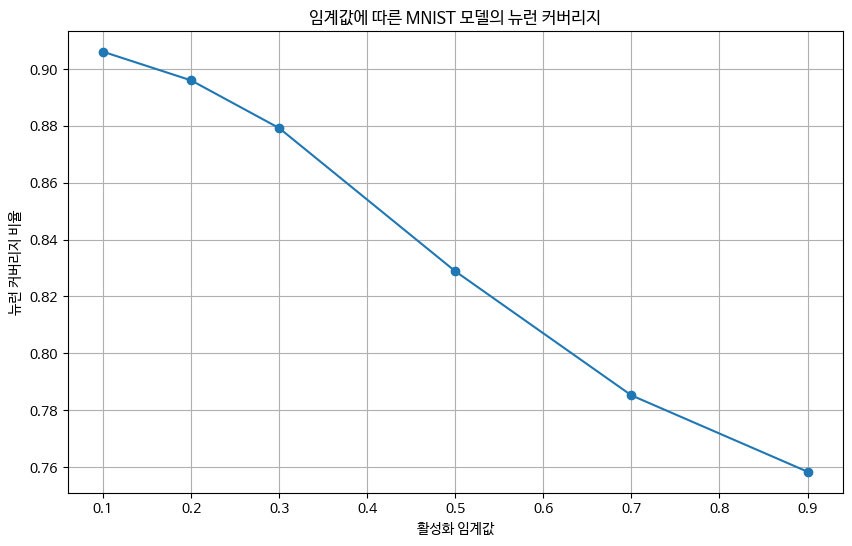

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


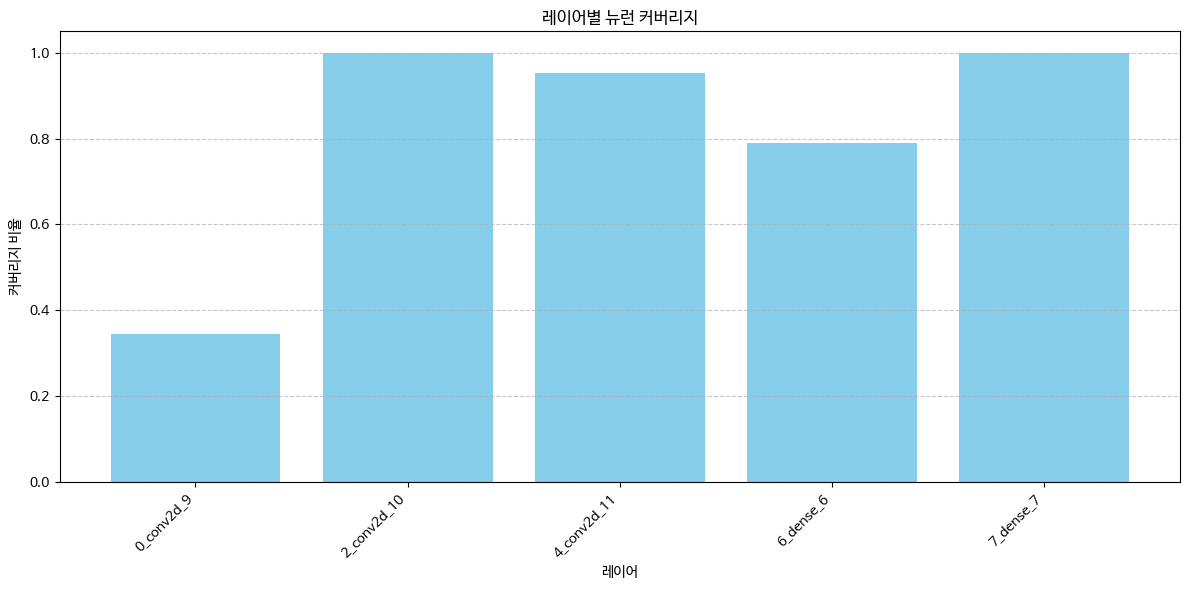

전체 뉴런 커버리지: 0.8289


In [25]:
# MNIST 뉴런 커버리지 테스트
print("\n1. MNIST 모델 뉴런 커버리지 테스트")
mnist_coverage = test_mnist_neuron_coverage()


2. HouseSales 모델 뉴런 커버리지 테스트
HouseSales 데이터셋을 성공적으로 로드했습니다.
저장된 모델이 없어 새로운 모델을 생성합니다.
Epoch 1/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5861 - mae: 0.5380 - val_loss: 0.2067 - val_mae: 0.3137
Epoch 2/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2540 - mae: 0.3501 - val_loss: 0.1861 - val_mae: 0.2854
Epoch 3/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2103 - mae: 0.3190 - val_loss: 0.1749 - val_mae: 0.2753
Epoch 4/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1886 - mae: 0.3043 - val_loss: 0.1750 - val_mae: 0.2792
Epoch 5/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1751 - mae: 0.2953 - val_loss: 0.1766 - val_mae: 0.2783


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1719 - mae: 0.2786
테스트 MAE: 0.2738

=== HouseSales 뉴런 커버리지 분석 ===
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
임계값 0.1에서의 뉴런 커버리지: 1.0000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
임계값 0.2에서의 뉴런 커버리지: 1.0000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
임계값 0.3에서의 뉴런 커버리지: 1.0000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
임계값 0.5에서의 뉴런 커버리지: 1.0000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

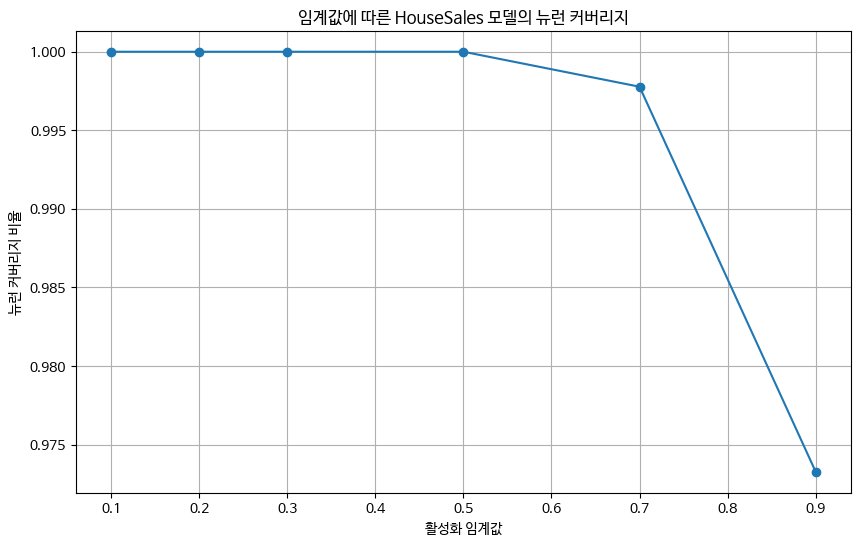

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


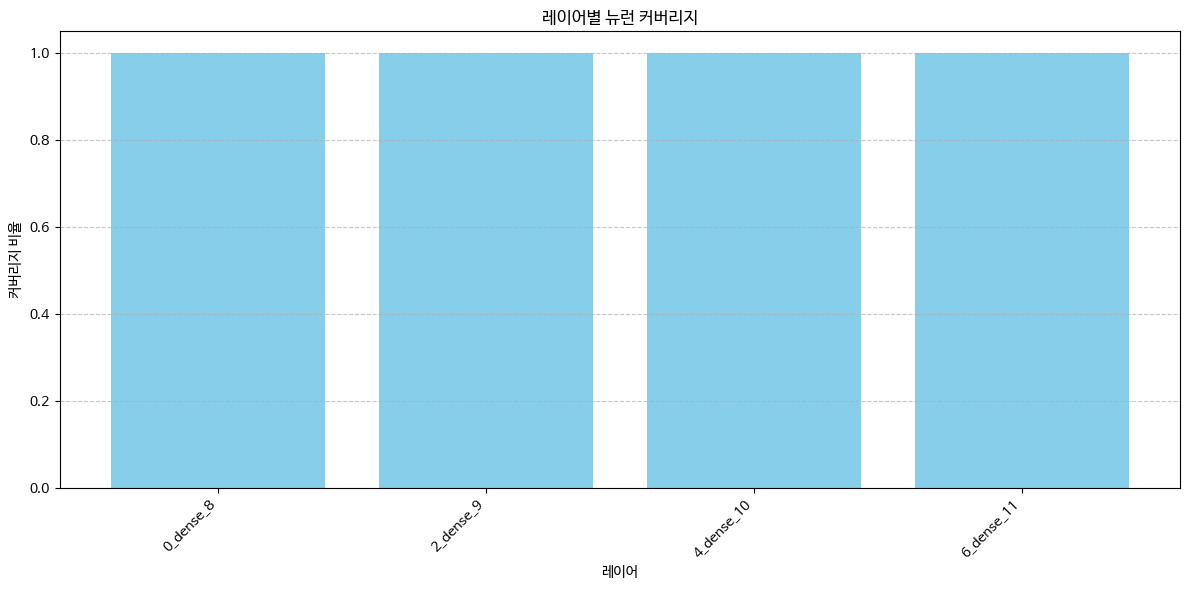

전체 뉴런 커버리지: 1.0000


In [28]:
# HouseSales 뉴런 커버리지 테스트
print("\n2. HouseSales 모델 뉴런 커버리지 테스트")
housesales_coverage = test_housesales_neuron_coverage()

In [29]:
print("\n=== 뉴런 커버리지 테스트 완료 ===")


=== 뉴런 커버리지 테스트 완료 ===


## **2. PyTorch 기반**

### **2.1 기본 설정**

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
# 시드 설정
torch.manual_seed(6)
np.random.seed(6)

In [34]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 중인 디바이스: {device}')

사용 중인 디바이스: cpu


### **2.2 뉴런 커버리지 측정 클래스**

In [35]:
# 뉴런 커버리지 측정을 위한 클래스
class NeuronCoverage:
    def __init__(self, model, threshold=0.5):
        """
        뉴런 커버리지를 측정하는 클래스

        Args:
            model: 테스트할 PyTorch 모델
            threshold: 뉴런 활성화 임계값 (기본값: 0.5)
        """
        self.model = model
        self.threshold = threshold
        self.covered_neurons = {}
        self.total_neurons = {}
        self.layer_names = []
        self.hooks = []
        self.activation_maps = {}

        # 레이어 후크 설정
        for name, module in model.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                layer_name = name
                self.layer_names.append(layer_name)

                # 출력 형태 확인
                if isinstance(module, nn.Linear):
                    num_neurons = module.out_features
                else:  # Conv2d
                    num_neurons = module.out_channels

                self.covered_neurons[layer_name] = np.zeros(num_neurons, dtype=bool)
                self.total_neurons[layer_name] = num_neurons

                # 활성화 값을 저장하기 위한 후크 등록
                hook = module.register_forward_hook(self._create_hook(layer_name))
                self.hooks.append(hook)

    def _create_hook(self, layer_name):
        """
        각 레이어의 출력을 캡처하는 후크 함수 생성
        """
        def hook(module, input, output):
            self.activation_maps[layer_name] = output
        return hook

    def update_coverage(self, dataloader):
        """
        주어진 데이터로더의 데이터에 대한 뉴런 커버리지 업데이트

        Args:
            dataloader: PyTorch DataLoader
        """
        self.model.eval()  # 평가 모드 설정

        with torch.no_grad():
            for batch in dataloader:
                if isinstance(batch, list) and len(batch) == 2:
                    inputs, _ = batch  # (inputs, labels)
                else:
                    inputs = batch  # inputs만 있는 경우

                inputs = inputs.to(device)

                # 모델 실행하여 활성화 맵 수집
                _ = self.model(inputs)

                # 각 레이어의 활성화 값 분석
                for layer_name in self.layer_names:
                    layer_output = self.activation_maps[layer_name]

                    # 출력 형태 조정
                    if len(layer_output.shape) == 4:  # Conv2D 출력 (배치, 채널, 높이, 너비)
                        # 각 필터별로 최대 활성화 값 계산
                        layer_output = torch.max(layer_output.view(layer_output.size(0), layer_output.size(1), -1), dim=2)[0]

                    # 임계값보다 큰 활성화를 가진 뉴런 찾기
                    activated_neurons = (layer_output > self.threshold).any(dim=0).cpu().numpy()
                    self.covered_neurons[layer_name] = np.logical_or(
                        self.covered_neurons[layer_name], activated_neurons
                    )

    def get_coverage(self):
        """
        전체 뉴런 커버리지 비율 반환

        Returns:
            float: 뉴런 커버리지 비율 (0~1)
        """
        total_covered = sum(np.sum(covered) for covered in self.covered_neurons.values())
        total_neurons = sum(self.total_neurons.values())
        return total_covered / total_neurons

    def get_layer_coverage(self):
        """
        레이어별 뉴런 커버리지 반환

        Returns:
            dict: 레이어별 커버리지 비율
        """
        layer_coverage = {}
        for layer_name in self.layer_names:
            covered = np.sum(self.covered_neurons[layer_name])
            total = self.total_neurons[layer_name]
            layer_coverage[layer_name] = covered / total
        return layer_coverage

    def visualize_coverage(self):
        """
        뉴런 커버리지를 시각화
        """
        layer_coverage = self.get_layer_coverage()
        layers = list(layer_coverage.keys())
        coverage_values = list(layer_coverage.values())

        plt.figure(figsize=(12, 6))
        plt.bar(layers, coverage_values, color='skyblue')
        plt.xlabel('레이어')
        plt.ylabel('커버리지 비율')
        plt.title('레이어별 뉴런 커버리지')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        print(f"전체 뉴런 커버리지: {self.get_coverage():.4f}")

    def __del__(self):
        """
        등록된 후크 제거
        """
        for hook in self.hooks:
            hook.remove()

### **2.3 각 데이터셋을 위한 모델 정의**

In [36]:
# MNIST 모델 정의
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [37]:
# HouseSales 모델 정의
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.layer3 = nn.Linear(128, 64)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.layer4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.layer1(x)))
        x = self.relu(self.batch_norm2(self.layer2(x)))
        x = self.relu(self.batch_norm3(self.layer3(x)))
        x = self.layer4(x)
        return x

### **2.4 MNIST에 대한 테스트**

In [39]:
# MNIST 데이터셋에 대한 뉴런 커버리지 테스트
def test_mnist_neuron_coverage():
    # MNIST 데이터셋 로드
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )

    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 모델 로드 또는 생성
    try:
        model = MnistCNN().to(device)
        model.load_state_dict(torch.load('model_neuron_coverage_mnist_cnn_pytorch.pth', map_location=device))
        print("저장된 MNIST 모델을 불러왔습니다.")
    except:
        print("저장된 모델이 없어 새로운 모델을 생성합니다.")

        # 학습 데이터셋 로드
        train_dataset = torchvision.datasets.MNIST(
            root='./data', train=True, download=True, transform=transform
        )

        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

        # 모델 초기화
        model = MnistCNN().to(device)

        # 손실 함수와 옵티마이저 정의
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 간략화된 학습 (실제 사용 시에는 더 많은 에포크 필요)
        for epoch in range(1):
            model.train()
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                if (i+1) % 100 == 0:
                    print(f'Epoch [{epoch+1}/1], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # 모델 저장
        torch.save(model.state_dict(), 'model_neuron_coverage_mnist_cnn_pytorch.pth')

    # 테스트 정확도 확인
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'테스트 정확도: {100 * correct / total:.2f}%')

    # 뉴런 커버리지 분석
    print("\n=== MNIST 뉴런 커버리지 분석 ===")

    # 임계값 목록
    thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

    # 다양한 임계값에 대한 뉴런 커버리지 측정
    coverage_results = {}
    for threshold in thresholds:
        neuron_coverage = NeuronCoverage(model, threshold=threshold)

        # 테스트 데이터의 일부만 사용 (전체 사용 시 시간 소요가 클 수 있음)
        sample_size = min(1000, len(test_dataset))
        sampler = torch.utils.data.RandomSampler(test_dataset, num_samples=sample_size, replacement=False)
        sample_loader = DataLoader(test_dataset, batch_size=64, sampler=sampler)

        # 커버리지 업데이트
        neuron_coverage.update_coverage(sample_loader)
        coverage = neuron_coverage.get_coverage()
        coverage_results[threshold] = coverage
        print(f"임계값 {threshold}에서의 뉴런 커버리지: {coverage:.4f}")

    # 임계값에 따른 뉴런 커버리지 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(list(coverage_results.keys()), list(coverage_results.values()), marker='o')
    plt.xlabel('활성화 임계값')
    plt.ylabel('뉴런 커버리지 비율')
    plt.title('임계값에 따른 MNIST 모델의 뉴런 커버리지')
    plt.grid(True)
    plt.show()

    # 임계값 0.5에서의 레이어별 커버리지 시각화
    neuron_coverage = NeuronCoverage(model, threshold=0.5)
    neuron_coverage.update_coverage(sample_loader)
    neuron_coverage.visualize_coverage()

    return coverage_results

### **2.5 HouseSales에 대한 테스트**

In [40]:
# HouseSales 데이터셋에 대한 뉴런 커버리지 테스트
def test_housesales_neuron_coverage():
    # HouseSales 데이터셋 클래스 정의
    class HouseSalesDataset(Dataset):
        def __init__(self, features, targets=None):
            self.features = torch.tensor(features, dtype=torch.float32)
            if targets is not None:
                self.targets = torch.tensor(targets, dtype=torch.float32).reshape(-1, 1)
            else:
                self.targets = None

        def __len__(self):
            return len(self.features)

        def __getitem__(self, idx):
            if self.targets is not None:
                return self.features[idx], self.targets[idx]
            else:
                return self.features[idx]

    # HouseSales 데이터셋 로드
    def load_house_data(file_path='https://raw.githubusercontent.com/SkyLectures/LectureMaterials/refs/heads/main/datasets/S03-10-02-02_01-kc_house_data.csv'):
        try:
            # 데이터 읽기
            df = pd.read_csv(file_path)

            # 필요없는 컬럼 제거
            df = df.drop(['id', 'date'], axis=1)

            # 결측치 처리
            df = df.dropna()

            # 이상치 확인 및 제거
            q_low = df['price'].quantile(0.01)
            q_high = df['price'].quantile(0.99)
            df = df[(df['price'] > q_low) & (df['price'] < q_high)]

            # 특성(X)과 타겟(y) 분리
            X = df.drop('price', axis=1)
            y = df['price']

            # 학습 및 테스트 데이터 분리
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

            # 특성 스케일링 (표준화)
            scaler_X = StandardScaler()
            X_train = scaler_X.fit_transform(X_train)
            X_test = scaler_X.transform(X_test)

            # 타겟 변수도 스케일링
            scaler_y = StandardScaler()
            y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
            y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

            return X_train, X_test, y_train, y_test, scaler_y
        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {e}")
            # 오류 발생 시 간단한 더미 데이터 반환
            X_train = np.random.randn(100, 10)
            X_test = np.random.randn(20, 10)
            y_train = np.random.randn(100)
            y_test = np.random.randn(20)
            scaler_y = None
            return X_train, X_test, y_train, y_test, scaler_y

    # 데이터 로드
    X_train, X_test, y_train, y_test, scaler_y = load_house_data()
    print("HouseSales 데이터셋을 로드했습니다.")

    # 데이터셋 및 데이터로더 생성
    test_dataset = HouseSalesDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 모델 로드 또는 생성
    try:
        input_dim = X_train.shape[1]
        model = HousePriceModel(input_dim).to(device)
        model.load_state_dict(torch.load('model_neuron_coverage_house_price_dnn_pytorch.pth', map_location=device))
        print("저장된 HouseSales 모델을 불러왔습니다.")
    except:
        print("저장된 모델이 없어 새로운 모델을 생성합니다.")

        # 데이터셋 및 데이터로더 생성
        train_dataset = HouseSalesDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # 모델 초기화
        input_dim = X_train.shape[1]
        model = HousePriceModel(input_dim).to(device)

        # 손실 함수와 옵티마이저 정의
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 간략화된 학습
        for epoch in range(5):
            model.train()
            running_loss = 0.0
            for features, targets in train_loader:
                features, targets = features.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f'Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}')

        # 모델 저장
        torch.save(model.state_dict(), 'model_neuron_coverage_house_price_dnn_pytorch.pth')

    # 테스트 손실 확인
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = nn.MSELoss()(outputs, targets)
            test_loss += loss.item()

    print(f'테스트 MSE: {test_loss/len(test_loader):.4f}')

    # 뉴런 커버리지 분석
    print("\n=== HouseSales 뉴런 커버리지 분석 ===")

    # 임계값 목록
    thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

    # 다양한 임계값에 대한 뉴런 커버리지 측정
    coverage_results = {}
    for threshold in thresholds:
        neuron_coverage = NeuronCoverage(model, threshold=threshold)

        # 커버리지 업데이트
        neuron_coverage.update_coverage(test_loader)
        coverage = neuron_coverage.get_coverage()
        coverage_results[threshold] = coverage
        print(f"임계값 {threshold}에서의 뉴런 커버리지: {coverage:.4f}")

    # 임계값에 따른 뉴런 커버리지 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(list(coverage_results.keys()), list(coverage_results.values()), marker='o')
    plt.xlabel('활성화 임계값')
    plt.ylabel('뉴런 커버리지 비율')
    plt.title('임계값에 따른 HouseSales 모델의 뉴런 커버리지')
    plt.grid(True)
    plt.show()

    # 임계값 0.5에서의 레이어별 커버리지 시각화
    neuron_coverage = NeuronCoverage(model, threshold=0.5)
    neuron_coverage.update_coverage(test_loader)
    neuron_coverage.visualize_coverage()

    return coverage_results

### **2.6 테스트 수행**

In [41]:
print("=== 뉴런 커버리지 테스트 시작 ===")

=== 뉴런 커버리지 테스트 시작 ===



1. MNIST 모델 뉴런 커버리지 테스트


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.95MB/s]


저장된 모델이 없어 새로운 모델을 생성합니다.
Epoch [1/1], Step [100/469], Loss: 0.3244
Epoch [1/1], Step [200/469], Loss: 0.0961
Epoch [1/1], Step [300/469], Loss: 0.1621
Epoch [1/1], Step [400/469], Loss: 0.1041
테스트 정확도: 98.34%

=== MNIST 뉴런 커버리지 분석 ===
임계값 0.1에서의 뉴런 커버리지: 0.8162
임계값 0.2에서의 뉴런 커버리지: 0.8120
임계값 0.3에서의 뉴런 커버리지: 0.8120
임계값 0.5에서의 뉴런 커버리지: 0.8120
임계값 0.7에서의 뉴런 커버리지: 0.8120
임계값 0.9에서의 뉴런 커버리지: 0.8120


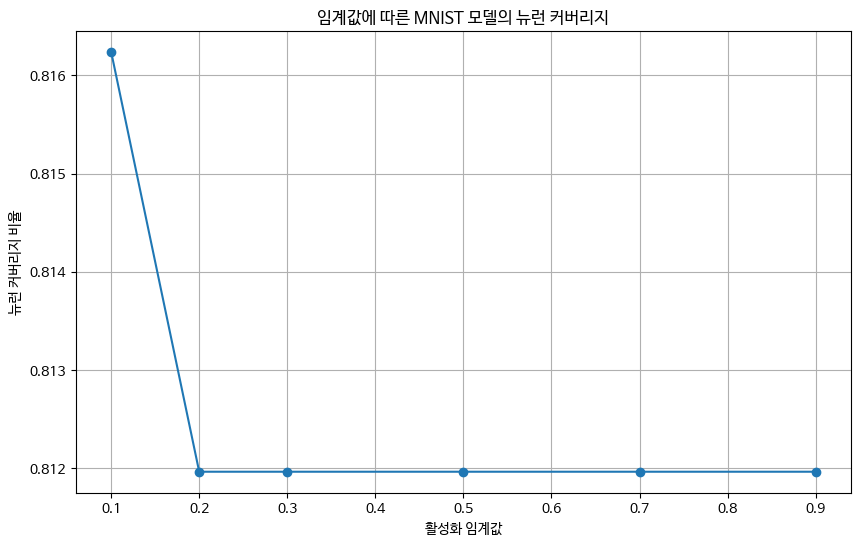

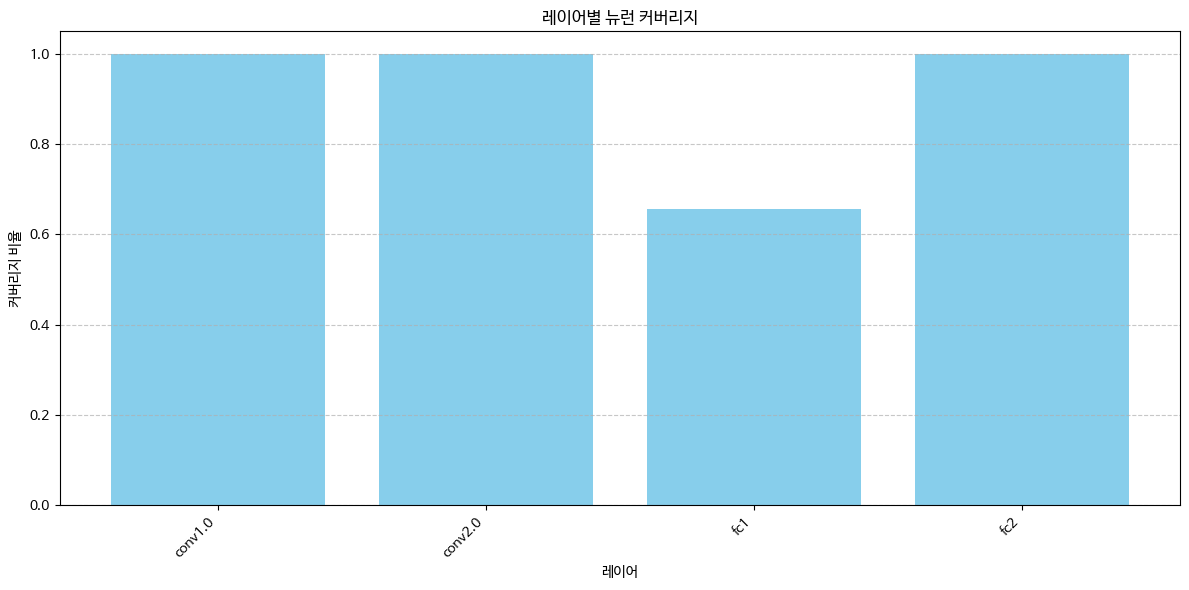

전체 뉴런 커버리지: 0.8120


In [42]:
# MNIST 뉴런 커버리지 테스트
print("\n1. MNIST 모델 뉴런 커버리지 테스트")
mnist_coverage = test_mnist_neuron_coverage()


2. HouseSales 모델 뉴런 커버리지 테스트
HouseSales 데이터셋을 로드했습니다.
저장된 모델이 없어 새로운 모델을 생성합니다.
Epoch [1/5], Loss: 0.2680
Epoch [2/5], Loss: 0.2149
Epoch [3/5], Loss: 0.1981
Epoch [4/5], Loss: 0.1899
Epoch [5/5], Loss: 0.1780
테스트 MSE: 0.1458

=== HouseSales 뉴런 커버리지 분석 ===
임계값 0.1에서의 뉴런 커버리지: 1.0000
임계값 0.2에서의 뉴런 커버리지: 1.0000
임계값 0.3에서의 뉴런 커버리지: 1.0000
임계값 0.5에서의 뉴런 커버리지: 0.9978
임계값 0.7에서의 뉴런 커버리지: 0.9955
임계값 0.9에서의 뉴런 커버리지: 0.9911


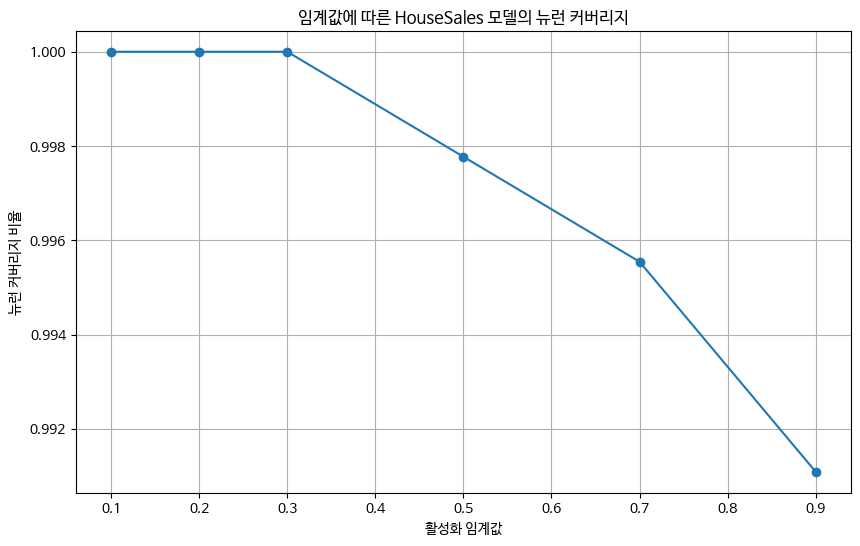

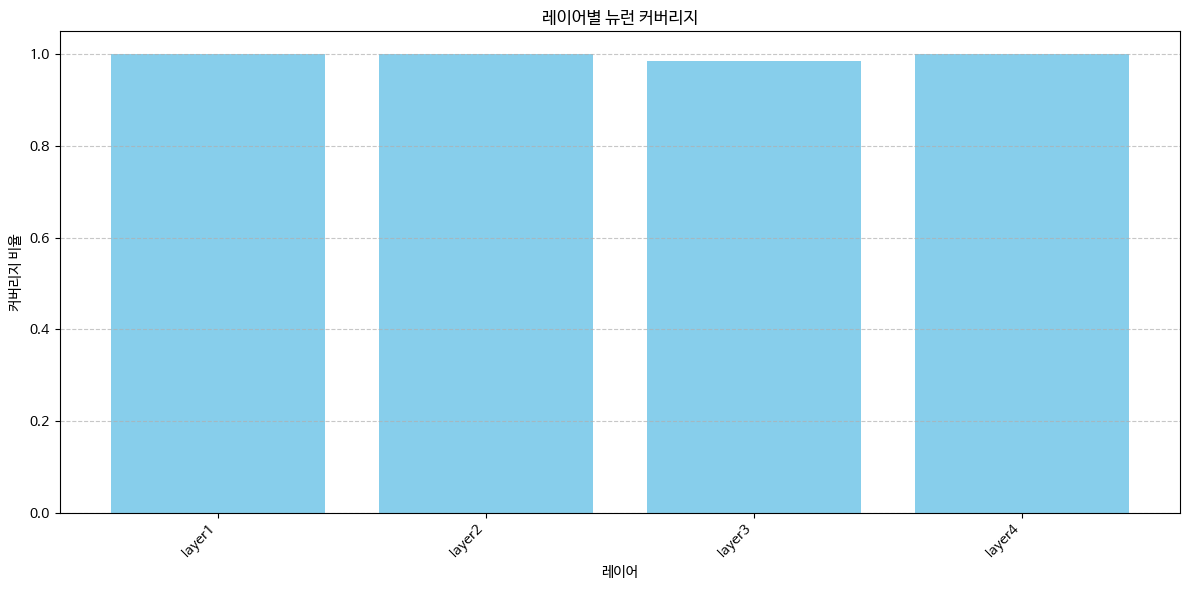

전체 뉴런 커버리지: 0.9978


In [43]:
# HouseSales 뉴런 커버리지 테스트
print("\n2. HouseSales 모델 뉴런 커버리지 테스트")
housesales_coverage = test_housesales_neuron_coverage()

In [44]:
# 결과 비교
print("\n=== 뉴런 커버리지 결과 비교 ===")
print("임계값 0.5 기준:")
print(f"MNIST 모델: {mnist_coverage[0.5]:.4f}")
print(f"HouseSales 모델: {housesales_coverage[0.5]:.4f}")

# 결론
print("\n=== 뉴런 커버리지 테스트 결론 ===")
print("1. 임계값이 낮을수록 더 많은 뉴런이 활성화되어 커버리지가 높아집니다.")
print("2. 모델 구조와 데이터셋 특성에 따라 뉴런 커버리지 패턴이 다르게 나타납니다.")
print("3. 뉴런 커버리지는 테스트 데이터의 다양성과 모델의 일반화 능력을 평가하는 지표로 활용될 수 있습니다.")
print("4. 높은 뉴런 커버리지가 반드시 좋은 모델 성능을 의미하지는 않지만, 모델이 다양한 입력 패턴을 처리할 수 있는지 평가하는 데 도움이 됩니다.")


=== 뉴런 커버리지 결과 비교 ===
임계값 0.5 기준:
MNIST 모델: 0.8120
HouseSales 모델: 0.9978

=== 뉴런 커버리지 테스트 결론 ===
1. 임계값이 낮을수록 더 많은 뉴런이 활성화되어 커버리지가 높아집니다.
2. 모델 구조와 데이터셋 특성에 따라 뉴런 커버리지 패턴이 다르게 나타납니다.
3. 뉴런 커버리지는 테스트 데이터의 다양성과 모델의 일반화 능력을 평가하는 지표로 활용될 수 있습니다.
4. 높은 뉴런 커버리지가 반드시 좋은 모델 성능을 의미하지는 않지만, 모델이 다양한 입력 패턴을 처리할 수 있는지 평가하는 데 도움이 됩니다.
